Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 3


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [29]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

## Train, Test, Val Split.

In [47]:
# split data into train, val.
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)
# show the data frame shapes.
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

## Create Wrangle Function.

In [0]:
import numpy as np
from datetime import datetime

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""   
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # create buckets.
    # lga.
    bucket = X['lga'].value_counts()[:20].index
    X.loc[~X['lga'].isin(bucket), 'lga'] = 'Other'
    # ward.
    bucket = X['ward'].value_counts()[:20].index
    X.loc[~X['ward'].isin(bucket), 'ward'] = 'Other'
    # subvillage.
    bucket = X['subvillage'].value_counts()[:100].index
    X.loc[~X['subvillage'].isin(bucket), 'subvillage'] = 'Other'
    # funder.
    bucket = X['funder'].value_counts()[:20].index
    X.loc[~X['funder'].isin(bucket), 'funder'] = 'Other'
    # installer.
    bucket = X['installer'].value_counts()[:20].index
    X.loc[~X['installer'].isin(bucket), 'installer'] = 'Other'


    # use datetime.strptime and split date_recorded into year, month, day columns.
    year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year
    X['year'] = X['date_recorded'].map(year)
    month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
    X['month'] = X['date_recorded'].map(month)
    day = lambda x: datetime.strptime(x, "%Y-%m-%d" ).day
    X['day'] = X['date_recorded'].map(day)

    # remove duplicates/bad columns.
    X = X.drop(columns=['date_recorded', 'quantity_group', 'quality_group', 'waterpoint_type_group', 'extraction_type_group', 'payment_type', 'num_private'])

    # Engineer feature: how many years from construction_year to date_recorded
    X['years_missing'] = X['year'] - X['construction_year']
    # Create new feature pump_age.
    X['pump_age'] = 2013 - X['construction_year']
    X.loc[X['pump_age'] == 2013, 'pump_age'] = 0
    X.loc[X['pump_age'] == 0, 'pump_age'] = 10
    
    # return the wrangled dataframe
    return X


# use the wrange function on the tran, val, test data.
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

## Set the Target, Select Numeric & Cardinality Features.

In [0]:
# create the target as status_group.
target = 'status_group'
# set the features, remove target and id column.
train_features = train.drop(columns=[target, 'id'])
# group all the numeric features.
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
# group the cardinality of the nonnumeric features.
cardinality = train_features.select_dtypes(exclude='number').nunique()
# group all categorical features with cardinality <= 50.
categorical_features = cardinality[cardinality <= 100].index.tolist()
# create features with numeric + categorical
features = numeric_features + categorical_features
# create the new vaules with the new features/target data.
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## Random Forest Classifier Model + OrdinalEncoder.

In [53]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
   ce.OrdinalEncoder(),
   SimpleImputer(strategy='median'),
   StandardScaler(),
   RandomForestClassifier(max_depth=None, max_features=0.275, min_samples_leaf=2, min_samples_split=2, n_estimators=344, random_state=42,  n_jobs=-1) 
)

pipeline.fit(X_train, y_train)
print ('Training Accuracy', pipeline.score(X_train, y_train))
print ('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Training Accuracy 0.9407407407407408
Validation Accuracy 0.8157407407407408


## Cross Validation.

In [41]:
from sklearn.model_selection import cross_val_score

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                        scoring='accuracy')
print(f'MAE for {k} folds', scores)

MAE for 3 folds [0.80027774 0.80011364 0.79582044]


In [42]:
print(scores.mean())
scores.std()

0.7987372764857182


0.0020636003172654397

In [44]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

Model Hyperparameters:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


## RandomizedSearchCV, Best Hyper Parameters.

In [52]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

param_distributions = {
    'simpleimputer__strategy':['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(20, 500),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__min_samples_split': range(2, 10),
    'randomforestclassifier__min_samples_leaf': range(1, 10)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            f

In [0]:
# show the best hyper parameters/cross validation score.
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.3332232242012898, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 213, 'simpleimputer__strategy': 'mean'}
Cross-validation accuracy 0.8094276094276094


In [0]:
# create best estimator.
pipeline = search.best_estimator_

In [0]:
# fit best estimator on the data.
pipeline.fit(X_train, y_train)
# show the vaildation accuracy score.
print('Validation accuracy:', pipeline.score(X_val, y_val))

Validation accuracy: 0.813973063973064


## Bar Plot the Feature Importances.

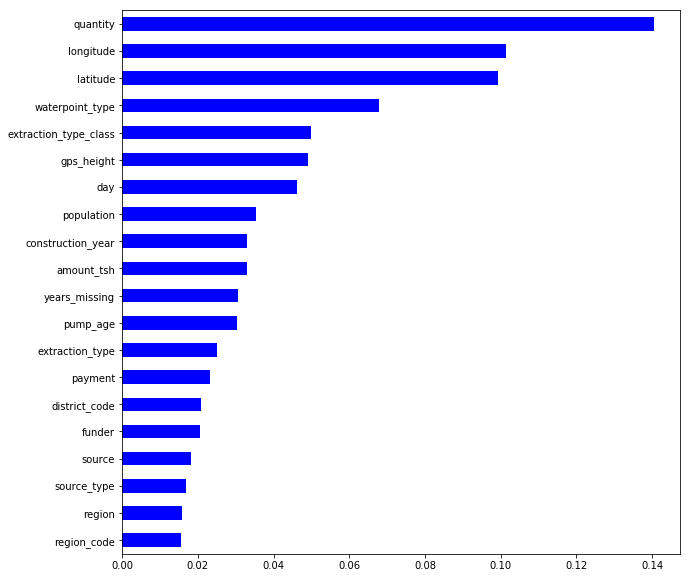

In [0]:
import matplotlib.pyplot as plt
rf = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

importances = pd.Series(rf.feature_importances_, encoded.columns)

n = 20
plt.figure(figsize=(10, 10))
importances.sort_values()[-n:].plot.barh(color='b');

In [0]:
y_pred = pipeline.predict(X_test)

## Create the data frame file for download.

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-01.csv', index=False)

In [0]:
!head submission-01.csv

id,status_group
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,functional
28965,non functional
36301,non functional


In [0]:
from google.colab import files 
files.download('submission-01.csv')